# Movie recommendation on Amazon SageMaker with Neural Networks and MXNet

### Step SM1: Download ml-100k data  
***The data sets are needed to train our Neural Network. We use the 100,000 movie ratings given by users from MovieLens data sets.***

#####  The data sets are needed to train our Factorization Machine. We use the 100,000 movie ratings given by users from MovieLens data sets.

In [1]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray

import pandas as pd
import numpy as np

In [2]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::349934754982:role/service-role/AmazonSageMaker-ExecutionRole-20190123T091078
CPU times: user 442 ms, sys: 20.2 ms, total: 463 ms
Wall time: 481 ms


In [3]:
s3_bucket = sess.default_bucket()
s3_prefix = 'movielens'

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-349934754982


### Data Information
*ua.base : data for training*  
*ua.test : data for test/validation*  
*Headers/columns :* ***user id | item id | rating (1-5) | timestamp***

In [4]:
train_df = pd.read_csv('./ml-100k/ua.base', sep='\t', names=['USER_ID', 'ITEM_ID', 'RATING', 'TIMESTAMP'])
test_df = pd.read_csv('./ml-100k/ua.test', sep='\t', names=['USER_ID', 'ITEM_ID', 'RATING', 'TIMESTAMP'])
pd.set_option('display.max_rows', 5)
train_df

,USER_ID,ITEM_ID,RATING,TIMESTAMP
0,1,1,5,874965758
1,1,2,3,876893171
...,...,...,...,...
90568,943,1228,3,888640275
90569,943,1330,3,888692465


In [31]:
def max_id(fname):
    mu = 0
    mi = 0
    with open(fname) as f:
        for line in f:
            tks = line.strip().split('\t')
            if len(tks) != 4:
                continue
            mu = max(mu, int(tks[0]))
            mi = max(mi, int(tks[1]))
    return mu + 1, mi + 1
max_users, max_items = max_id('./ml-100k/ua.base')
(max_users, max_items)

(944, 1683)

In [5]:
X_train=train_df[['USER_ID','ITEM_ID']].values
y_train=train_df[['RATING']].values

In [6]:
X_test=test_df[['USER_ID','ITEM_ID']].values
y_test=test_df[['RATING']].values

In [36]:
np.save('./data/train/train_X.npy', X_train)
np.save('./data/train/train_Y.npy', y_train)
np.save('./data/test/test_X.npy', X_test)
np.save('./data/test/test_Y.npy', y_test)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/visualization.py:263: RuntimeWarning: There are multiple variables with the same name in your graph, this may result in cyclic graph. Repeated names: mfnet8_dropout0_fwd
  warnings.warn(warning_message, RuntimeWarning)


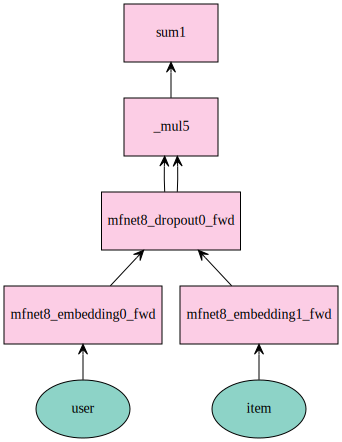

In [56]:
class MFNet(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFNet, self).__init__()
        
        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb
        
        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)
            self.dropout = gluon.nn.Dropout(dropout_p)
            
    def forward(self, users, items):
        a = self.user_embeddings(users)
        b = self.item_embeddings(items)
        predictions = self.dropout(a) * self.dropout(b)      
        predictions = mx.sym.sum(predictions, axis=1)
        return predictions
    
   
net1 = MFNet(max_users, max_items, 64)
net1.initialize(mx.init.Xavier(), ctx=ctx)
mx.viz.plot_network(net1(mx.sym.var('user'), mx.sym.var('item')), node_attrs={"fixedsize":"false"})

In [13]:
mkdir ./data/ ./data/train ./data/test

mkdir: cannot create directory ‘./data/’: File exists


In [14]:
np.save('./data/train/train_X.npy', X_train)
np.save('./data/train/train_Y.npy', y_train)
np.save('./data/test/test_X.npy', X_test)
np.save('./data/test/test_Y.npy', y_test)

In [37]:
traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
testdata_s3_prefix = '{}/data/test'.format(s3_prefix)
output_s3 = 's3://{}/{}/models/'.format(s3_bucket, s3_prefix)
code_location_s3 = 's3://{}/{}/codes'.format(s3_bucket, s3_prefix)

In [38]:
train_s3 = sess.upload_data(path='./data/train/', bucket=s3_bucket, key_prefix=traindata_s3_prefix)
test_s3 = sess.upload_data(path='./data/test/', bucket=s3_bucket, key_prefix=testdata_s3_prefix)

In [39]:
inputs = {'train':train_s3, 'test': test_s3}

In [40]:
from sagemaker.mxnet import MXNet

In [63]:
import json
params=json.dumps({'batch-size': 32,'epochs': 10,'learning-rate': 0.1,'embedding-size':32,'max-users':max_users,'max-items':max_items})

In [ ]:
params[]

In [82]:
mxnet_estimator = MXNet('train.py',
                        role=role,
                        train_instance_type='ml.c4.xlarge',
                        train_instance_count=1,
                        framework_version='1.3.0',
                        py_version='py3',
                        hyperparameters={'batch-size': 32,'epochs': 10,'learning-rate': 0.1,'embedding-size':32,'max-users':max_users,'max-items':max_items})
mxnet_estimator.fit(inputs)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-349934754982
INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2019-03-03-19-18-33-524


2019-03-03 19:18:33 Starting - Starting the training job...
2019-03-03 19:18:35 Starting - Launching requested ML instances......
2019-03-03 19:19:44 Starting - Preparing the instances for training......
2019-03-03 19:20:53 Downloading - Downloading input data
2019-03-03 19:20:53 Training - Downloading the training image.
2019-03-03 19:20:58,563 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2019-03-03 19:20:58,567 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-03 19:20:58,592 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_MODEL_DIR': '/opt/ml/model', 'SM_NUM_GPUS': '0', 'SM_INPUT_DATA_CONFIG': '{"test":{"RecordWrapperType":"None","S3DistributionType":"FullyReplicated","TrainingInputMode":"File"},"train":{"RecordWrapperType":"None","S3DistributionType":"FullyReplicated","TrainingInputMode":"File"}}', 'SM_CHANNEL_TEST': '/opt/ml/input/data/test', 'SM_HOSTS': '["algo-1"]', 'SM_INPUT_D


2019-03-03 19:21:06 Training - Training image download completed. Training in progress.EPOCH 0: RMSE ON TRAINING and TEST: 1.1252351704290358. 0.989341813888031
epoch: 1
EPOCH 1: RMSE ON TRAINING and TEST: 1.0031465023250903. 0.936087139606139
epoch: 2
EPOCH 2: RMSE ON TRAINING and TEST: 0.9845669178639428. 0.8950961152600214
epoch: 3
EPOCH 3: RMSE ON TRAINING and TEST: 0.9637280385373003. 0.8384792989574528
epoch: 4
EPOCH 4: RMSE ON TRAINING and TEST: 0.9678241907540014. 0.787247534208355
epoch: 5
EPOCH 5: RMSE ON TRAINING and TEST: 0.9630974030090591. 0.7384571821413374
epoch: 6
EPOCH 6: RMSE ON TRAINING and TEST: 0.9744493848186428. 0.7047448303749182
epoch: 7
EPOCH 7: RMSE ON TRAINING and TEST: 0.9868324112083953. 0.6673069271949524
epoch: 8
EPOCH 8: RMSE ON TRAINING and TEST: 1.0018961880166652. 0.6486358289392707
epoch: 9

2019-03-03 19:31:32 Uploading - Uploading generated training model
2019-03-03 19:31:32 Failed - Training job failed
EPOCH 9: RMSE ON TRAINING and TEST: 1.0150

ValueError: Error for Training job sagemaker-mxnet-2019-03-03-19-18-33-524: Failed Reason: AlgorithmError: ExecuteUserScriptError:
Command "/usr/bin/python -m train --batch-size 32 --embedding-size 32 --epochs 10 --learning-rate 0.1 --max-items 1683 --max-users 944"

In [100]:
def eval_net(data, net):
    acc = mx.metric.RMSE()
    for i, (user, item, label) in enumerate(data):
        user = user.as_in_context(ctx).reshape((len(user),))
        item = item.as_in_context(ctx).reshape((len(user),))
        label = label.as_in_context(ctx).reshape((len(user),))
        predictions = net(user, item)
        loss = loss_function(predictions, label)
        acc.update(preds=predictions, labels=label)
    90570%batch_size
    return acc.get()[1]

In [72]:
eval_net(train_data_iter, net)

3.6948865924526633

In [86]:
ratings = nd.dot(net.user_embeddings.weight.data(ctx=ctx), net.item_embeddings.weight.data(ctx=ctx).T).asnumpy()
ratings.shape

(944, 1683)

In [93]:
net.forward(mx.nd.array([0]),mx.nd.array([1]))


[ 0.08441807]
<NDArray 1 @cpu(0)>

In [90]:
ratings[0,1]

0.084418066

In [90]:
ratings[0,1]

0.084418066